# QR CODES MAZE
## Rachele Guzzon
### *Final Submission, DATA AND MACHINE LEARNING FOR CREATIVE PRACTICE*

The provided notebook outlines the procedure for generating multiple QR posters designed for quiz-related purposes.

> *More informations on the way I created this process will be defined in the separate documentation, I will limit this notebook to more technical explenations and suggestions.*

### Steps:
- QR code generation
- beautification process
- composition



# QR codes generation

Using shorter links for simpler QR codes is more effective. I recommend utilizing a Google Form for this purpose, as it offers an integrated link shortening function and allows modifications even after the link is generated. This approach ensures flexibility in changing questions without the need to regenerate the QR code.

After obtaining the link, you can use [Antony's QR Toolkit](https://qrcode.antfu.me/). This webpage, curated by Antony Fu, is designed specifically for creating QR codes that will be beautified.

## Image modification
The QR beautification model works well with different image shapes and sizes, even when the QR code isn't centered, as shown in this example with postcard-like shapes.

I would suggest [Canva](https://www.canva.com/) as a straightforward software to get the QR's to the desired format

>If using the free version of Colab, avoid increasing the size too much to prevent potential crashes during generation.

# Beautification process
I'm using [monster-labs/control_v1p_sd15_qrcode_monster](https://huggingface.co/monster-labs/control_v1p_sd15_qrcode_monster) model form hugging face to generate the QR codes

> Make sure you are using T4 GPU hardware accelleration on collab or the following code will not work

In [1]:
#importing hugging face,  an account with a key is needed to use this model
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()

In [2]:
import sys

if 'google.colab' in sys.modules:
    !pip install --upgrade transformers diffusers accelerate
    !pip install gradio

import torch
from diffusers.utils import load_image, make_image_grid
import numpy as np
import cv2
from PIL import Image

import gradio as gr

In [3]:
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    DEISMultistepScheduler,
    HeunDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
)

controlnet = ControlNetModel.from_pretrained(
    "monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
).to("cuda")

SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "DPM++ Karras": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True),
    "Heun": lambda config: HeunDiscreteScheduler.from_config(config),
    "Euler a": lambda config: EulerAncestralDiscreteScheduler.from_config(config),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
    "DDIM": lambda config: DDIMScheduler.from_config(config),
    "DEIS": lambda config: DEISMultistepScheduler.from_config(config),
}

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Negative prompting:
The incorporation of a negative prompt has proven to enhance the model's
ability to generate better images.
In addition to the standard word, I've introduced "trypophobia" (the fear of holes) into the prompts. This inclusion is particularly relevant due to the distinctive shape of QR codes, and it aims to create appropriate results.

In [4]:
generator = torch.manual_seed(0)

def qr_generate(qrcode_image, prompt, controlnet_conditioning_scale = float(0.9)):

  negative_prompt = "ugly, disfigured, low quality, blurry, nsfw, trypophobia"
  image = pipe(
      prompt=prompt,
      negative_prompt=negative_prompt,
      image=qrcode_image,
      width=qrcode_image.width,
      height=qrcode_image.height,
      guidance_scale=float(20.0),#20
      controlnet_conditioning_scale=controlnet_conditioning_scale,#1.5
      generator=generator,
      num_inference_steps=25,
  ).images[0]

  return image

### Loading the images:
Conditions on the monster-labs huggingface page:
 - Use a higher error correction level to make it easier to read (sometimes a lower level can be easier to read if smaller in size).
 - Use a gray background for the rest of the image to make the code integrate better.

In [5]:
post_qr_image_num = load_image(
    "https://rachypan.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff5a23d1c-44ec-4833-883f-612a45d52c29%2F5fc77219-d093-49d8-9129-ce66b615a95f%2Fnumber_of_answers_post.png?table=block&id=2cc663c8-d4da-44b3-a4fa-db1689177a58&spaceId=f5a23d1c-44ec-4833-883f-612a45d52c29&width=1120&userId=&cache=v2"
)

post_qr_image_invalsi = load_image(
    "https://rachypan.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff5a23d1c-44ec-4833-883f-612a45d52c29%2F20478087-f906-4c49-8984-d24ead806ecf%2Fform_invalsi_mate_post.png?table=block&id=8ddf3c9f-16a3-4f5b-9614-6a9be81e5bc4&spaceId=f5a23d1c-44ec-4833-883f-612a45d52c29&width=1120&userId=&cache=v2"
)

post_qr_image_final = load_image(
    "https://rachypan.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff5a23d1c-44ec-4833-883f-612a45d52c29%2Ff0e673ef-ea48-4442-ba9e-8fe4a99c47a3%2Ffinal_question_post.png?table=block&id=fe9fe86b-266a-4383-b709-0ced958974c6&spaceId=f5a23d1c-44ec-4833-883f-612a45d52c29&width=1120&userId=&cache=v2"
)

post_qr_image_cards = load_image(
    "https://rachypan.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Ff5a23d1c-44ec-4833-883f-612a45d52c29%2F1f13c58a-0182-44b8-8e35-b197de7548d1%2Fcards_in_a_deck_post.png?table=block&id=768a6a67-2818-4141-83ec-fd0d2ee96ed8&spaceId=f5a23d1c-44ec-4833-883f-612a45d52c29&width=1120&userId=&cache=v2"
)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

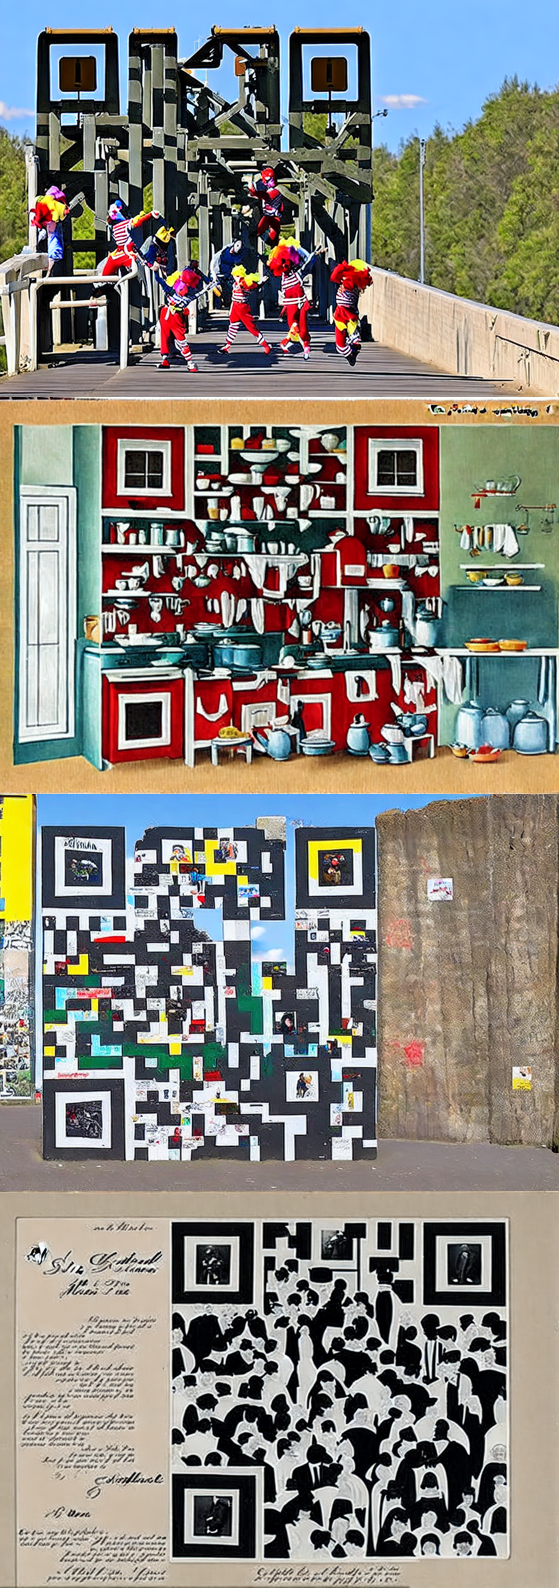

In [6]:
cond = 1.5

prompt = "clowns on a bridge"
gen_post_qr_image_num = qr_generate(post_qr_image_num, prompt, cond)

prompt = "a postcard of an old italian kitchen "
gen_post_qr_image_invalsi = qr_generate(post_qr_image_invalsi,prompt,cond)

prompt = "a postcard of the berlin wall"
gen_post_qr_image_final = qr_generate(post_qr_image_final,prompt, cond)

prompt = "a postcard of a 1940's wedding"
gen_post_qr_image_cards = qr_generate(post_qr_image_cards,prompt, cond)

make_image_grid([gen_post_qr_image_num.resize((559,397)), gen_post_qr_image_invalsi.resize((559,397)),gen_post_qr_image_final.resize((559,397)) , gen_post_qr_image_cards.resize((559,397))], rows=4, cols=1)

# Conditional Values:

Using different values for the conditional to understand the level of abstraction that still creates a readable result.

### Controlnet guidance scale: Set the controlnet guidance scale value:
- High values: The generated QR code will be more readable.
- Low values: The generated QR code will be more creative.

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

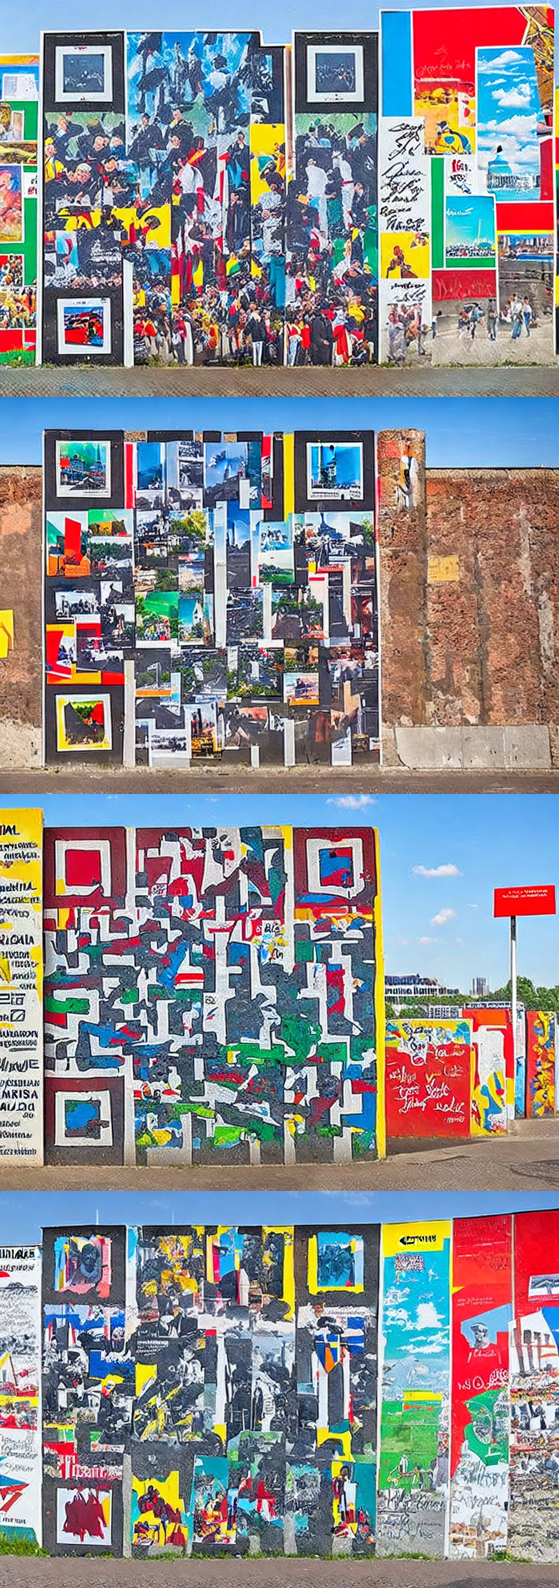

In [ ]:
prompt = "a postcard of the berlin wall"
gen_post_qr_image_final1 = qr_generate(post_qr_image_final,prompt, 1.26)
gen_post_qr_image_final2 = qr_generate(post_qr_image_final,prompt, 1.25)
gen_post_qr_image_final3 = qr_generate(post_qr_image_final,prompt, 1.25)
gen_post_qr_image_final4 = qr_generate(post_qr_image_final,prompt, 1.27)

make_image_grid([gen_post_qr_image_final1.resize((559,397)), gen_post_qr_image_final2.resize((559,397)),gen_post_qr_image_final3.resize((559,397)) , gen_post_qr_image_final4.resize((559,397))], rows=4, cols=1)


## App for easier generation created with gradio

The app makes it easier for someone without coding knowledge to access the QR code beautification.

> I've created a new function to test different parameters in the development phase.

In [7]:
def qr_generate_app(qrcode_image_link, prompt, controlnet_conditioning_scale = float(0.9)):

  qrcode_image = load_image(qrcode_image_link)

  negative_prompt = "ugly, disfigured, low quality, blurry, nsfw, trypophobia"
  image = pipe(
      prompt=prompt,
      negative_prompt=negative_prompt,
      image=qrcode_image,
      width=qrcode_image.width,
      height=qrcode_image.height,
      guidance_scale=float(20.0),
      controlnet_conditioning_scale=controlnet_conditioning_scale,
      generator=generator,
      num_inference_steps=25,
  ).images[0]

  return image

In [8]:
demo = gr.Interface(
    fn = qr_generate_app,
    inputs=[
        # gr.Image(type="pil"), #previous test with image
        "text",
        "text",
        gr.Slider(0.1, 2.0, value=1.2, label="controlnet_conditioning_scale", info="The higher the value the more readable the qr is"),
        ],

    outputs=["image"],
    title = """
    QR MAZIFIER
    """,

   description = """
    The app accepts a link to a QR code image that can be accessed online.
   >I suggest creating a notion page and publishing it as it generates the best results. *Examples of Qrcodes can be found on [my notion page](https://rachypan.notion.site/QR-codes-postcards-e9ae105fcc8f451aadb66372200dc7cf).*

   The prompt will then guide the beautification, while the slider controlls the closeness to the initial code.
    """
    )


demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3fe1ef812c3dc5be51.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
